### 1. Import Packages
#### Please import pandas_datareader package using 'pip install pandas_datareader'.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

### 2. Loading the Dataset

In [2]:
start = (2000, 1, 1)  # 2000-01-01 
start_time = datetime.datetime(*start)  
end = (2020, 12, 31) # 2020-12-31
end_time = datetime.datetime(*end) 

# Loading Samsung Electronic Co,. Ltd. (KS: 005930) Data from Yahoo Finance
df = pdr.DataReader('005930.KS', 'yahoo', start_time, end_time)

High : HIgh Price, The highest price at which a stock traded during that particular day

Low : Low Price, The lowest price at which a stock traded during that particular day

Open : Open Price, The stock price at which opens at the start of market

Close : Close Price, The stock closing at the end of the market hours

Volume : Trading volume during that particular day

Adj Close : A stock's closing price to reflect that stock's value after accounting for any corporate actions (Reference: https://help.yahoo.com/kb/SLN28256.html)

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,6110.0,5660.0,6000.0,6110.0,74195000.0,4740.119629
2000-01-05,6060.0,5520.0,5800.0,5580.0,74680000.0,4328.947754
2000-01-06,5780.0,5580.0,5750.0,5620.0,54390000.0,4359.979492
2000-01-07,5670.0,5360.0,5560.0,5540.0,40305000.0,4297.916992
2000-01-10,5770.0,5580.0,5600.0,5770.0,46880000.0,4476.349121


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-23,74000.0,72300.0,72400.0,73900.0,19411326.0,71766.921875
2020-12-24,78800.0,74000.0,74100.0,77800.0,32502870.0,75554.351562
2020-12-28,80100.0,78200.0,79000.0,78700.0,40085044.0,76428.375000
2020-12-29,78900.0,77300.0,78800.0,78300.0,30339449.0,77953.601562
2020-12-30,81300.0,77300.0,77400.0,81000.0,29417421.0,80641.656250


In [5]:
X = df # Using high price, low price, Open price, Close price, Volume, and Adjusted Close Price to predict adjusted close price
y = df.iloc[:, 5:6] #Predicting adjusted close price

### 3. Scaling and Converting Data

We can see that there is a big difference between volume and other values. In this case, LSTM models need to recognize the difference between these two scales: volume and the rest values, which can be a burden to train data. Therefore, we reduce by scaling all variables from 0 to 1 to reduce the burden on the model.

In [6]:
MMS_1 = MinMaxScaler()
MMS_2 = MinMaxScaler()

X_data = MMS_1.fit_transform(X)
y_data = MMS_2.fit_transform(y) 

# Input Variables (6 variables)
X_train = X_data[:4780, :] #We trained 2000 - 2018 data including high price, low price, open price, close price, volume, and adj close data
X_test = X_data[4780:5273, :] #To verify trained model, we used 2019 - 2020 data as the test set

# Output Variables (adjusted close price)
y_train = y_data[1:4781, :]
y_test = y_data[4781:, :] 

print("Training Set Shape", X_train.shape, y_train.shape)
print("Testing Set Shape", X_test.shape, y_test.shape) 

Training Set Shape (4780, 6) (4780, 1)
Testing Set Shape (493, 6) (493, 1)


In [7]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4780, 1, 6]) torch.Size([4780, 1])
Testing Shape torch.Size([493, 1, 6]) torch.Size([493, 1])


In [8]:
device = torch.device('cpu')

### 4. Building LSTM Model

In [9]:
class LSTM_model(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM_model, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #LSTM layer
    self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer

  def forward(self,x):
    h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
    # Decode the hidden state of the last time step
    out = self.fc(out[:, -1, :])
    return out

### 5. Setting Hyperparameters and Training Data

In [10]:
num_epochs = 5000
learning_rate = 0.001

input_size = 6 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked LSTM layers

num_classes = 1 #number of output classes 
LSTM_1 = LSTM_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(LSTM_1.parameters(), lr=learning_rate)  # adam optimizer

In [ ]:
for epoch in range(num_epochs+1):
    outputs = LSTM_1.forward(X_train_tensors_final.to(device)) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = loss_function(outputs, y_train_tensors.to(device))

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    
    if epoch % 100 == 0:
        print("Epoch: %d, Loss: %1.4f" % (epoch, loss.item())) 

In [12]:
plt.rcParams["figure.figsize"] = (32,18)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 20})

### 6. Results

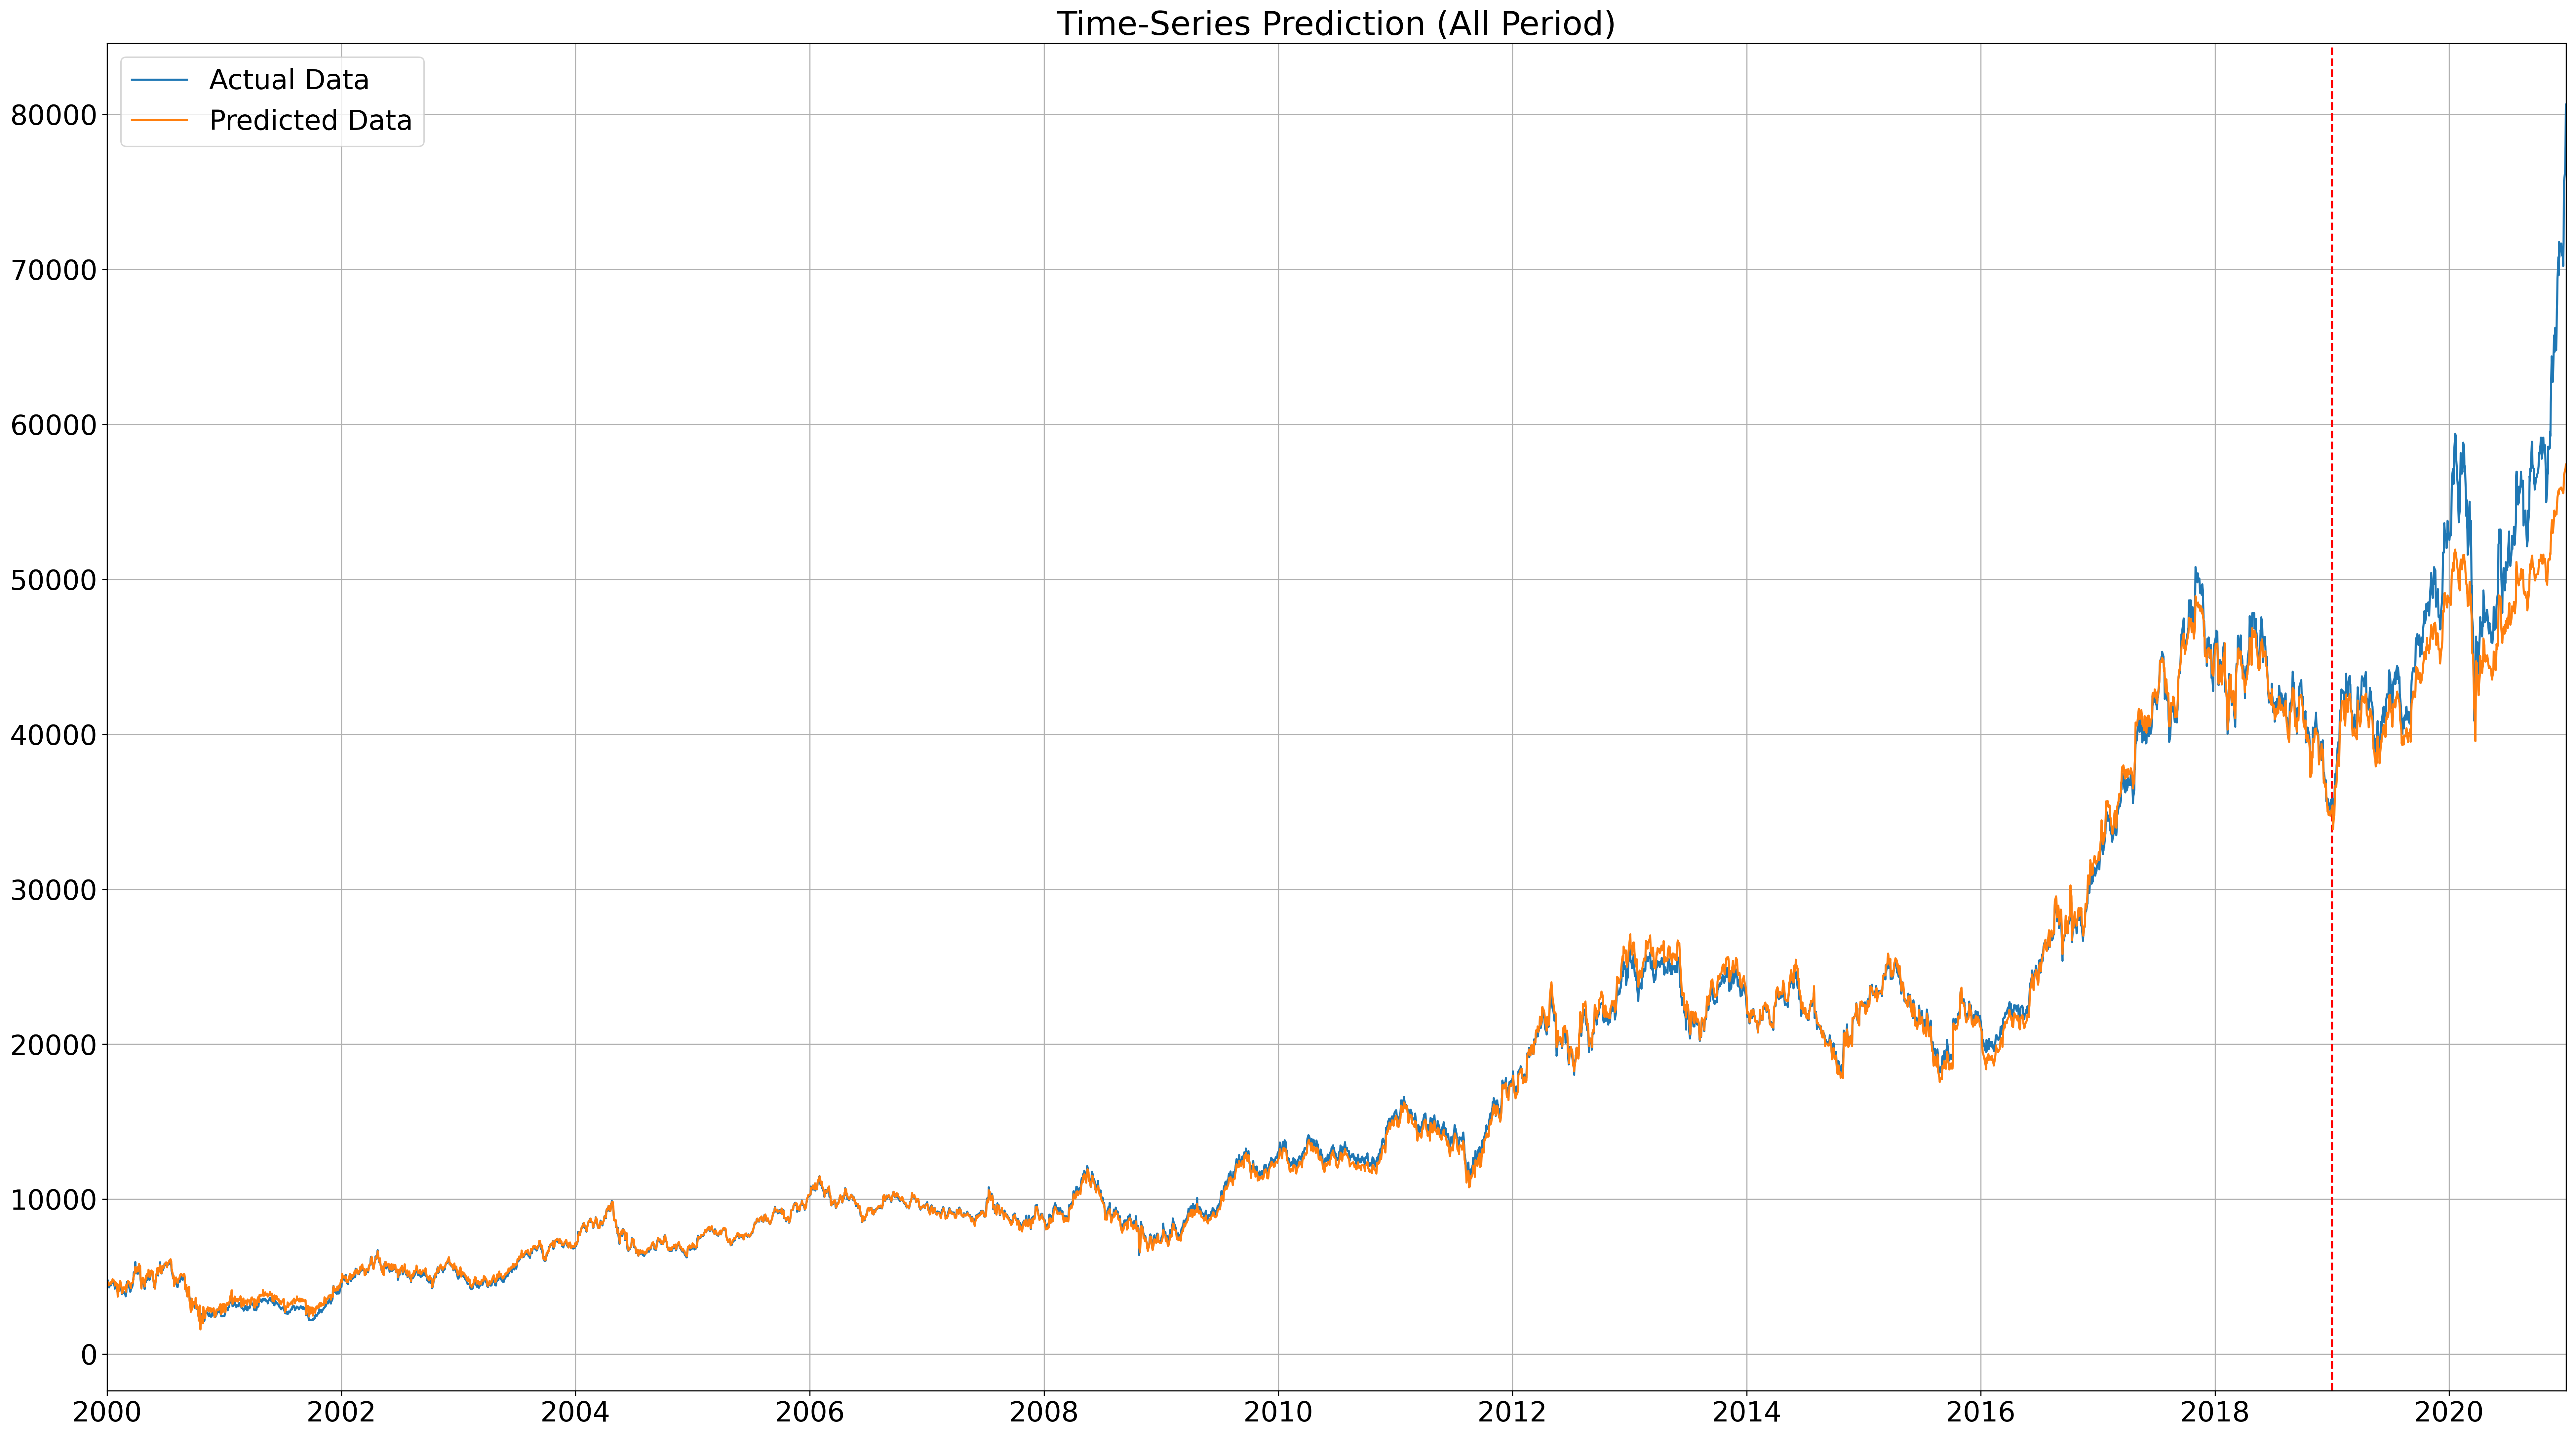

In [13]:
df_X = Variable(torch.Tensor(X_data)) #converting to Tensors
df_y = Variable(torch.Tensor(y_data))
#reshaping the dataset
df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
train_predict = LSTM_1(df_X.to(device))#forward pass
y_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
y_true = df_y.data.numpy()

y_predict = MMS_2.inverse_transform(y_predict) #reverse transformation
y_true = MMS_2.inverse_transform(y_true)

plt.xlim(datetime.datetime(2000, 1, 1), datetime.datetime(2020, 12, 31))
test_line = datetime.datetime(2019, 1, 1)
plt.axvline(x=test_line, c='r', linestyle='--') #size of the training set

plt.plot(df.index.to_pydatetime(), y_true, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), y_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (All Period)')
plt.legend()
plt.show() 

In [14]:
MSE = float(sum((y_true - y_predict)*(y_true - y_predict))/len(y_predict))
print('Mean Squared Error:', MSE)

Mean Squared Error: 2574967.25


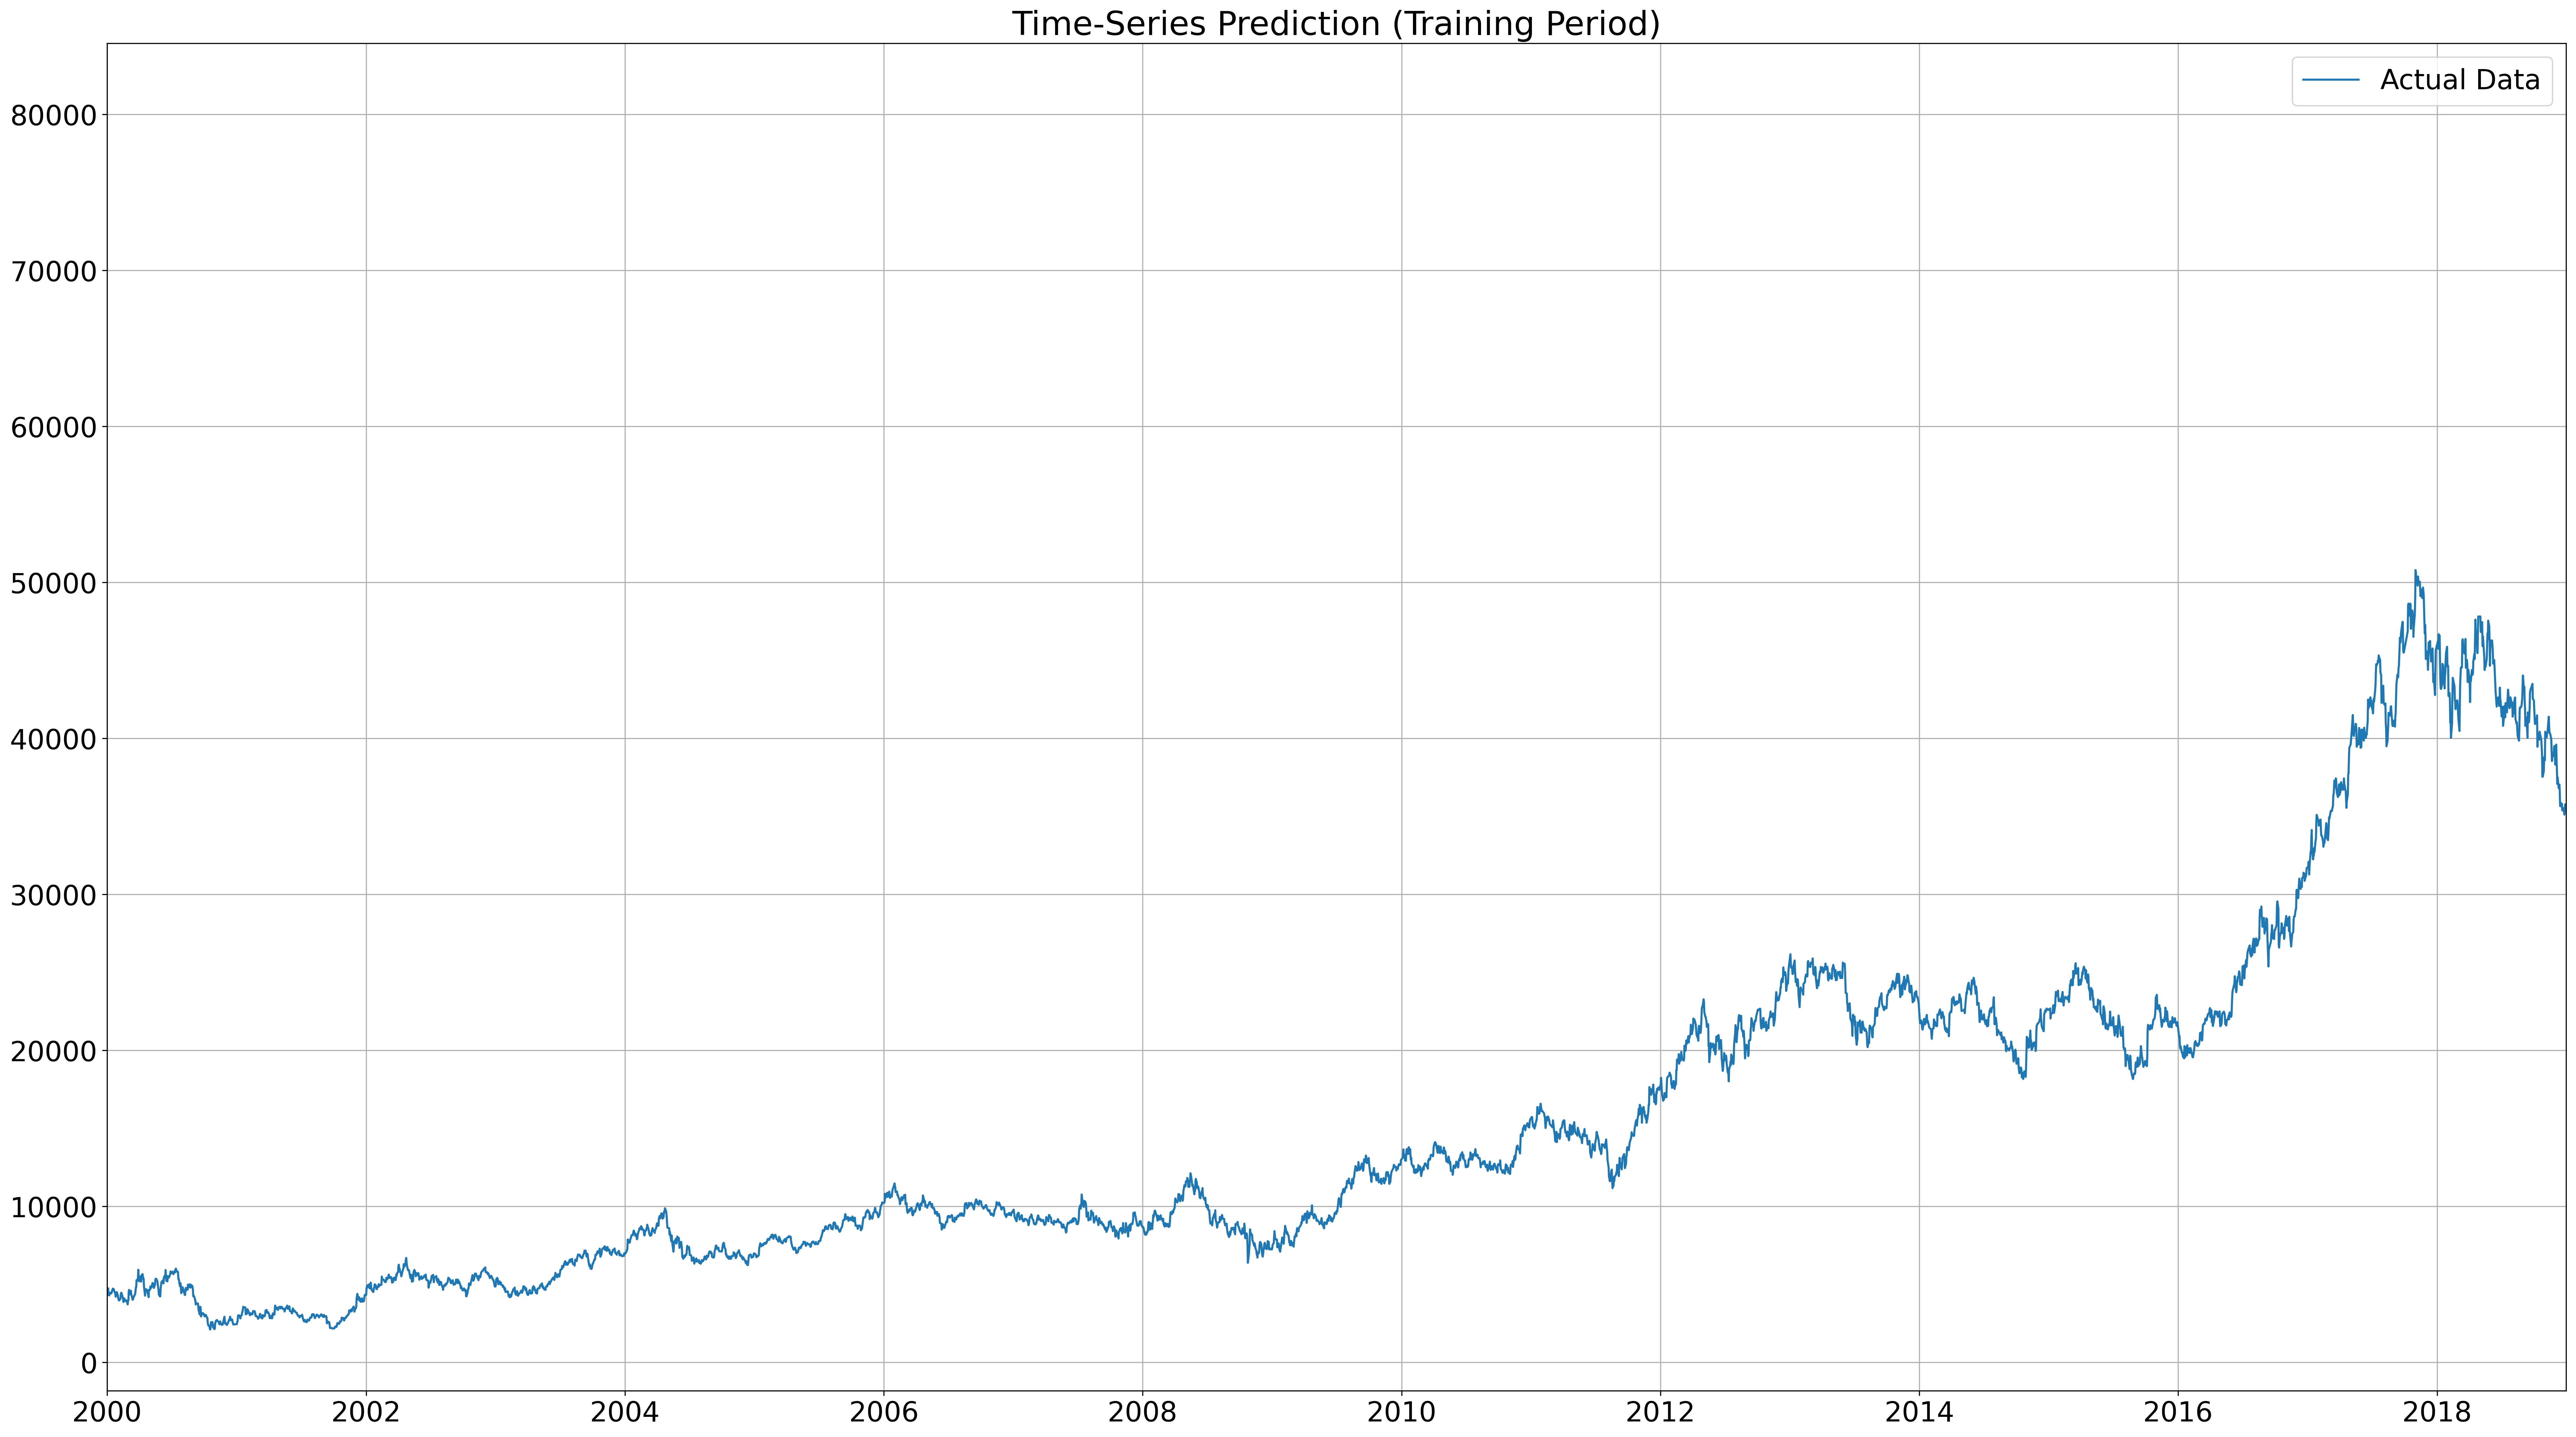

In [15]:
plt.xlim(datetime.datetime(2000, 1, 1), datetime.datetime(2018, 12, 31))
plt.plot(df.index.to_pydatetime(), y_true, label='Actual Data') # plot for actual data
plt.title('Time-Series Prediction (Training Period)')
plt.legend()
plt.show() 

In [16]:
MSE_train = float(sum((y_true[0:4780] - y_predict[0:4780])*(y_true[0:4780] - y_predict[0:4780]))/len(y_predict[0:4780]))
print('Mean Squared Error (Training Data):', MSE_train)

Mean Squared Error (Training Data): 146473.609375


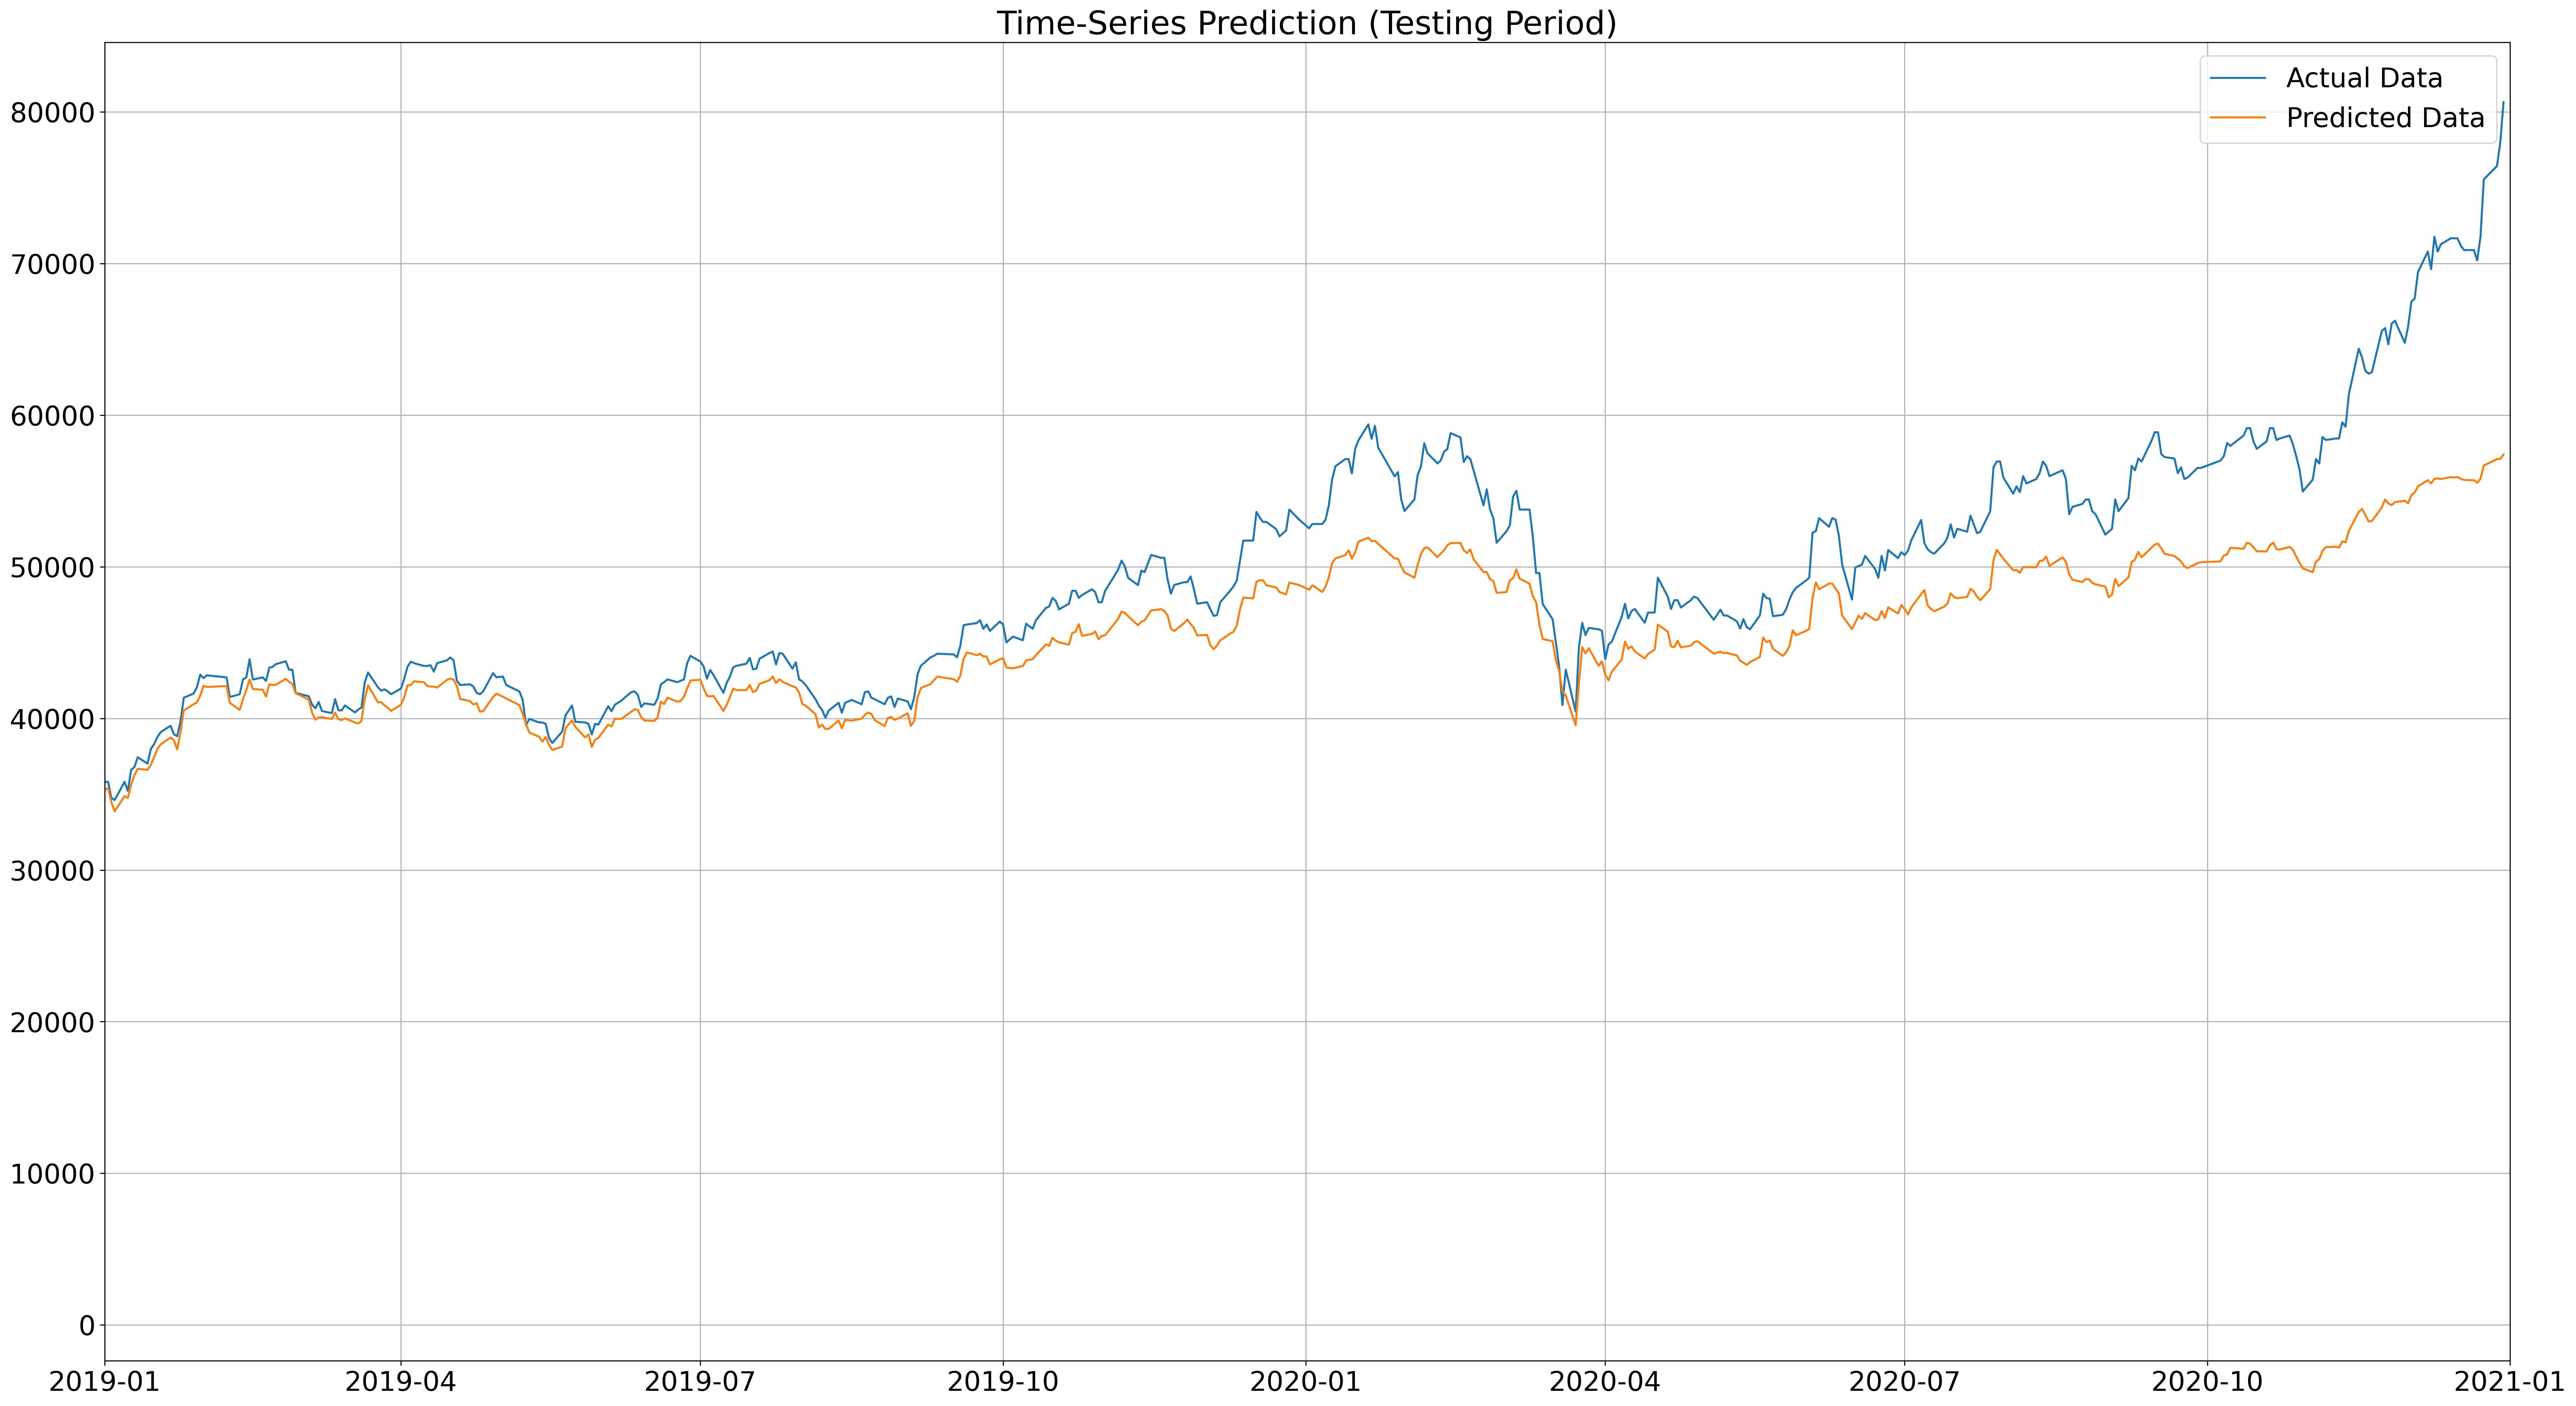

In [17]:
plt.xlim(datetime.datetime(2019, 1, 1), datetime.datetime(2021, 1, 1))
plt.plot(df.index.to_pydatetime(), y_true, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), y_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (Testing Period)')
plt.legend()
plt.show() 

In [18]:
MSE_test = float(sum((y_true[4780:] - y_predict[4780:])*(y_true[4780:] - y_predict[4780:]))/len(y_predict[4780:]))
print('Mean Squared Error (Test Data):', MSE_test)

Mean Squared Error (Test Data): 26073342.0
